<h1>Time series forecast using Transformer!</h1>
<p>Time series forecasting with Transformers leverages the model's ability to capture long-range dependencies and patterns in sequential data. Unlike traditional methods, Transformers use self-attention mechanisms to model temporal relationships, making them effective for complex forecasting tasks in fields like finance, weather prediction, and demand forecasting.</p>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path
import os
import keras
import json
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,6))
plt.rc('axes',titleweight='bold',titlesize='large',labelweight='bold',labelsize='large',grid=True)

In [ ]:
class timeseries_transformer():
    

In [9]:
with open(os.path.join(Path().cwd(),'parameter.json'),'r') as f:
    params=json.load(f)
    symbol=params['symbol']
    timeframe=params['timeframe']
    test_size=params['test_size']
df=pd.read_csv(os.path.join(Path().cwd(),f'data/{symbol}/{symbol}_{timeframe}.csv'),index_col=0,parse_dates=True)
price=df['Close']

In [10]:
seq_length = 10
n_features = 1
x=[]
y=[]
for i in range(len(price)-seq_length-1):
    x.append(price.iloc[i:i+seq_length].tolist())
    y.append(price.iloc[i+seq_length])
x,y=np.array(x),np.array(y)
x.shape,y.shape

((2492, 10), (2492,))

Text(0.5, 1.0, 'Data')

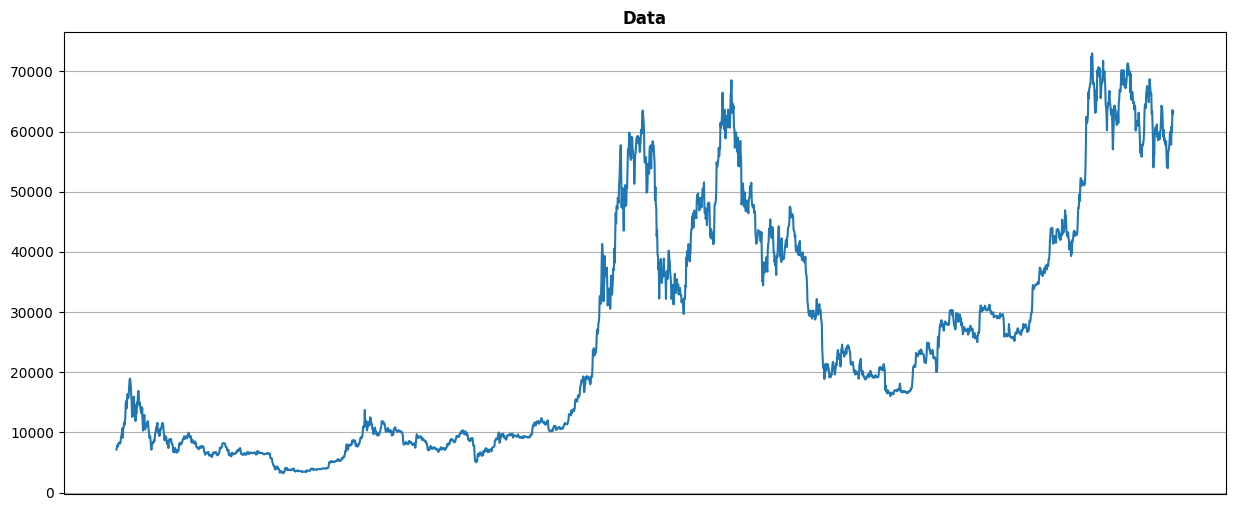

In [11]:
fg=plt.figure()
ax=fg.add_subplot()
ax.plot(price)
ax.set_xticks([],[])
ax.set_title('Data')

In [12]:
def positional_encoding(sequence_len, embedding_dim, n=10000):
    p=np.zeros((sequence_len, embedding_dim))
    for k in range(sequence_len):
        for i in np.arange(embedding_dim//2):
            denominator=np.power(n, 2*i/embedding_dim)
            p[k, 2*i]=np.sin(k/denominator)
            p[k, 2*i+1]=np.cos(k/denominator)
    return p

In [13]:
class multihead_attention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention_value(self, query, key, value):
        score=tf.matmul(query, key,transpose_b=True)
        dim_key=key.shape[-1]
        score/=np.sqrt(dim_key)
        weights=keras.ops.softmax(score, axis=-1)
        output=tf.matmul(weights, value)
        return output

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value = inputs
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention = self.attention_value(query, key, value)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        output = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(output)
        return output

In [14]:
class encoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = multihead_attention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1=layers.LayerNormalization()
        self.layernorm2=layers.LayerNormalization()
    def call(self, inputs):
        attn_output = self.att([inputs, inputs, inputs])
        add_norm1 = self.layernorm1(inputs + attn_output) #first add & normalize layer
        ffn_output = self.ffn(add_norm1)
        add_norm2=self.layernorm2(add_norm1 + ffn_output) # second add & normalize layer
        return add_norm2

In [15]:
def transformer_model(input_shape, num_heads, embed_dim, ff_dim):
    inputs = layers.Input(shape=input_shape)
    pos_enc = positional_encoding(input_shape[0], embed_dim)
    x = inputs + pos_enc

    encoder_block=encoder(embed_dim, num_heads, ff_dim)
    x=encoder_block(x)
    x=layers.Dense(20, activation="relu")(x)
    x=layers.Flatten()(x)
    outputs = layers.Dense(input_shape[1])(x)

    model=tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
test_size=0.3
index=int(x.shape[0]*(1-test_size))
x_train=x[:index]
y_train=y[:index]
x_test=x[index:]
y_test=y[index:]
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1744, 10), (1744,), (748, 10), (748,))

In [18]:
input_shape=(seq_length, n_features)
num_heads=8
embed_dim=512
ff_dim=64

model=transformer_model(input_shape, num_heads, embed_dim, ff_dim)
model.compile(optimizer="adam", loss='mse')

best_lost=keras.callbacks.ModelCheckpoint(filepath=os.path.join(Path().cwd(),'transformers.keras'),monitor='loss',mode='min',save_best_only=True)
model.fit(x,y, epochs=15,batch_size=32,callbacks=[best_lost])
predictions = model.predict(x)

Epoch 1/15


2024-09-22 00:49:03.564229: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 309ms/step - loss: 1008893120.0000
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 23s 299ms/step - loss: 991751680.0000
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 323ms/step - loss: 722893824.0000
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - loss: 469831040.0000
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - loss: 394591456.0000
Epoch 6/15
42/78 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - loss: 385162112.0000